In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
import optuna
import optuna.visualization as vis
from optuna.samplers import TPESampler
import sys
sys.path.append("../scripts")

import data
import utils
import models

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
seed = 42
(
    X_train,
    A_train,
    Y_train,
    X_val,
    A_val,
    Y_val,
    X_test,
    A_test,
    Y_test,
) = data.get_strat_split("compas", 6, 20, seed)
n_trials = 100

{'Other, Other': 0, 'African-American, Between 25 and 45': 1, 'African-American, Other': 2, 'Other, Between 25 and 45': 3, 'Caucasian, Between 25 and 45': 4, 'Caucasian, Other': 5}


In [4]:
# join train and validation
X_train = np.concatenate((X_train, X_val))
A_train = np.concatenate((A_train, A_val))
Y_train = np.concatenate((Y_train, Y_val))

In [10]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [11]:
def get_perf_fair(model, X_train, Y_train, A_train, X_val, Y_val, A_val):
    if np.unique(Y_train).shape[0] == 2:
        is_classification = True
    else:
        is_classification = False

    if is_classification:
        y_train_score = model.predict_proba(X_train)[:, 1]
        y_val_score = model.predict_proba(X_val)[:, 1]
        train_metrics = [
            log_loss(Y_train, y_train_score),
            utils.max_logloss_score(Y_train, y_train_score, A_train)
        ]
        val_metrics = [
            log_loss(Y_val, y_val_score),
            utils.max_logloss_score(Y_val, y_val_score, A_val)
        ]
    else:

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        train_metrics = [
            mse(Y_train, y_train_pred),
            utils.max_mse(Y_train, y_train_pred, A_train),
        ]
        val_metrics = [
           mse(Y_val, y_val_pred),
            utils.max_mse(Y_val, y_val_pred, A_val),
        ]
    train_metrics = [np.round(x, 4) for x in train_metrics]
    val_metrics = [np.round(x, 4) for x in val_metrics]

    return train_metrics, val_metrics

## LGBM Baseline

In [12]:
param_space = {
    "n_estimators": {"type": "int", "low": 10, "high": 1000, "log": True},
    "learning_rate": {"type": "float", "low": 1e-3, "high": 0.5, "log": True},
    "num_leaves": {"type": "int", "low": 2, "high": 256},
    "max_depth": {"type": "int", "low": 2, "high": 10},
    #"min_child_samples": {"type": "int", "low": 5, "high": 100},
    "min_child_weight": {"type": "float", "low": 1e-3, "high": 1e4, "log": True},
    #"reg_alpha": {"type": "float", "low": 1e-3, "high": 1e4, "log": True},
    "reg_lambda": {"type": "float", "low": 1e-3, "high": 1e4, "log": True},
}

### Best results if maximizing performance

In [ ]:
def run_trial(trial, X_train, Y_train, A_train, model_class, param_space):
    """Function to run a single trial of optuna."""
    params = {}
    for name, values in param_space.items():
        if values["type"] == "int":
            values_cp = {n: v for n, v in values.items() if n != "type"}
            params[name] = trial.suggest_int(name, **values_cp)
        elif values["type"] == "categorical":
            values_cp = {n: v for n, v in values.items() if n != "type"}
            params[name] = trial.suggest_categorical(name, **values_cp)
        elif values["type"] == "float":
            values_cp = {n: v for n, v in values.items() if n != "type"}
            params[name] = trial.suggest_float(name, **values_cp)

    is_classification = np.unique(Y_train).shape[0] == 2
    model = model_class(**params)
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    val_metrics = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]
        A_train_fold, A_val_fold = A_train[train_index], A_train[val_index]
        model.fit(X_train_fold, Y_train_fold, A_train_fold)
        if is_classification:
            Y_pred = model.predict_proba(X_val_fold)[:, 1]
            val_metrics.append(log_loss(Y_val_fold, Y_pred))
        else:
            Y_pred = model.predict(X_val_fold)
            val_metrics.append(mse(Y_val_fold, Y_pred))

    return np.mean(val_metrics)


#model_class = models.LGBMRegressor
model_class = models.LGBMClassifier
study = optuna.create_study(direction="minimize")
objective = lambda trial: run_trial(trial, X_train, Y_train, A_train, model_class, param_space)
study.optimize(
    objective,
    n_trials=100,
    n_jobs = 10,
    show_progress_bar = True
)
model = model_class(**study.best_params)
model.fit(X_train, Y_train, A_train)

In [17]:
get_perf_fair(model, X_train, Y_train, A_train, X_test, Y_test, A_test)

([0.6035, 0.6434], [0.6121, 0.6509])

### Best results if maximizing fairness

In [ ]:
def run_trial(trial, X_train, Y_train, A_train, model_class, param_space):
    """Function to run a single trial of optuna."""
    params = {}
    for name, values in param_space.items():
        if values["type"] == "int":
            values_cp = {n: v for n, v in values.items() if n != "type"}
            params[name] = trial.suggest_int(name, **values_cp)
        elif values["type"] == "categorical":
            values_cp = {n: v for n, v in values.items() if n != "type"}
            params[name] = trial.suggest_categorical(name, **values_cp)
        elif values["type"] == "float":
            values_cp = {n: v for n, v in values.items() if n != "type"}
            params[name] = trial.suggest_float(name, **values_cp)

    is_classification = np.unique(Y_train).shape[0] == 2
    model = model_class(**params)
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    val_metrics = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]
        A_train_fold, A_val_fold = A_train[train_index], A_train[val_index]
        model.fit(X_train_fold, Y_train_fold, A_train_fold)
        if is_classification:
            Y_pred = model.predict_proba(X_val_fold)[:, 1]
            val_metrics.append(utils.max_logloss_score(Y_val_fold, Y_pred, A_val_fold))
        else:
            Y_pred = model.predict(X_val_fold)
            val_metrics.append(utils.max_mse(Y_val_fold, Y_pred, A_val_fold))

    return np.mean(val_metrics)


#model_class = models.LGBMRegressor
model_class = models.LGBMClassifier
study = optuna.create_study(direction="minimize")
objective = lambda trial: run_trial(trial, X_train, Y_train, A_train, model_class, param_space)
study.optimize(
    objective,
    n_trials=100,
    n_jobs = 10,
    show_progress_bar = True
)
model = model_class(**study.best_params)
model.fit(X_train, Y_train, A_train)

In [21]:
print(study.best_params)
get_perf_fair(model, X_train, Y_train, A_train, X_test, Y_test, A_test)

{'n_estimators': 16, 'learning_rate': 0.16407604089186684, 'num_leaves': 223, 'max_depth': 4, 'min_child_weight': 1.2396173996004392, 'reg_lambda': 0.7156750275240331}


([0.6022, 0.6417], [0.6096, 0.6421])

## M²FGB

### Maximizing fairness

In [23]:
def run_trial(trial, X_train, Y_train, A_train, model_class, param_space):
    """Function to run a single trial of optuna."""
    params = {}
    for name, values in param_space.items():
        if values["type"] == "int":
            values_cp = {n: v for n, v in values.items() if n != "type"}
            params[name] = trial.suggest_int(name, **values_cp)
        elif values["type"] == "categorical":
            values_cp = {n: v for n, v in values.items() if n != "type"}
            params[name] = trial.suggest_categorical(name, **values_cp)
        elif values["type"] == "float":
            values_cp = {n: v for n, v in values.items() if n != "type"}
            params[name] = trial.suggest_float(name, **values_cp)

    is_classification = np.unique(Y_train).shape[0] == 2
    model = model_class(**params)
    kf = KFold(n_splits=4, shuffle=True, random_state=seed)
    val_metrics = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]
        A_train_fold, A_val_fold = A_train[train_index], A_train[val_index]
        model.fit(X_train_fold, Y_train_fold, A_train_fold)
        if is_classification:
            Y_pred = model.predict_proba(X_val_fold)[:, 1]
            val_metrics.append(utils.max_logloss_score(Y_val_fold, Y_pred, A_val_fold))
        else:
            Y_pred = model.predict(X_val_fold)
            val_metrics.append(utils.max_mse(Y_val_fold, Y_pred, A_val_fold))

    return np.mean(val_metrics)

### Tunning everything

In [24]:
param_space = {
    "n_estimators": {"type": "int", "low": 10, "high": 1000, "log": True},
    "learning_rate": {"type": "float", "low": 1e-3, "high": 0.5, "log": True},
    "num_leaves": {"type": "int", "low": 2, "high": 256},
    "max_depth": {"type": "int", "low": 2, "high": 10},
    #"min_child_samples": {"type": "int", "low": 5, "high": 100},
    "min_child_weight": {"type": "float", "low": 1e-3, "high": 1e4, "log": True},
    #"reg_alpha": {"type": "float", "low": 1e-3, "high": 1e4, "log": True},
    "reg_lambda": {"type": "float", "low": 1e-3, "high": 1e4, "log": True},
    "multiplier_learning_rate" : {"type" : "float", "low" : 1e-3, "high" : 0.5, "log" : True},
    "fair_weight" : {"type" : "float", "low" : 1e-3, "high" : 1.0, "log" : True},
}

In [ ]:
def model_class(**params):
    return models.M2FGBClassifier(dual_learning = "gradient_norm2", random_state = seed, **params)
study = optuna.create_study(direction="minimize")#, sampler = TPESampler(n_startup_trials=100, multivariate=True))
objective = lambda trial: run_trial(trial, X_train, Y_train, A_train, model_class, param_space)
study.optimize(
    objective,
    n_trials=100,
    n_jobs = 10,
    show_progress_bar = True
)
model = model_class(**study.best_params)
#model.fit(X_train, Y_train, A_train, X_val,Y_val, A_val)
model.fit(X_train, Y_train, A_train)

In [26]:
print(study.best_params)
get_perf_fair(model, X_train, Y_train, A_train, X_val, Y_val, A_val)

{'n_estimators': 129, 'learning_rate': 0.026246681205001305, 'num_leaves': 187, 'max_depth': 3, 'min_child_weight': 1.1380628983204732, 'reg_lambda': 0.4622155582638888, 'multiplier_learning_rate': 0.01784187065554556, 'fair_weight': 0.0015122176456112784}


([0.6048, 0.6431], [0.6057, 0.6281])

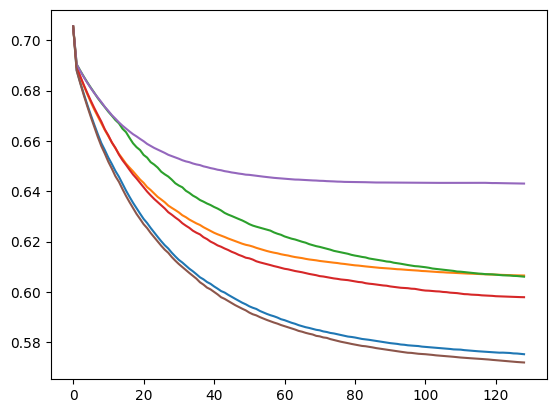

In [28]:
for i in range(6):
    plt.plot(model.group_losses[:, i])

In [ ]:
vis.plot_slice(study)

In [ ]:
vis.plot_param_importances(study)

In [31]:
y_train_pred = model.predict_proba(X_train)[:, 1]
thresh = utils.get_best_threshold(Y_train, y_train_pred)
y_val_pred = model.predict_proba(X_val)[:, 1] > thresh
y_train_pred = model.predict_proba(X_train)[:, 1] > thresh

In [32]:
1 - utils.min_accuracy(Y_val, y_val_pred, A_val)

0.634703196347032

In [33]:
1 - utils.min_balanced_accuracy(Y_val, y_val_pred, A_val)

0.6331713826969994